In [1]:
import numpy as np
import gpflow
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,roc_curve
from sklearn.metrics import precision_recall_curve,auc,average_precision_score
import pandas as pd


if __name__ == "__main__":
    mat = scipy.io.loadmat('Datos.mat')
    healthy = mat['Healthy_folds'][0]
    malign = mat['Malign_folds'][0]
    print(malign[4][0].shape)
    print(malign[3][0].shape)
    print(healthy[4][0].shape)
    print(healthy.shape)
    print(len(healthy))

(69, 10)
(50, 10)
(199, 10)
(5,)
5


In [2]:
# Función para crear el conjunto de training.
def createTrainingSet(healthy_set,malign_set,index):
    healthy_list = [healthy_set[ind][0] for ind in range(len(healthy_set)) if ind != index]
    malign_list = [malign_set[ind][0] for ind in range(len(malign_set)) if ind != index]
    
    trainSet = np.array(healthy_list[0])
    trainLabels = np.ones(healthy_list[0].shape[0])*(-1)
    trainSet = np.append(trainSet,malign_list[0],axis=0)
    trainLabels = np.append(trainLabels,np.ones(malign_list[0].shape[0]))
   
    for ind in range(1,len(healthy_list)):
        trainSet = np.append(trainSet,healthy_list[ind],axis=0)
        trainLabels = np.append(trainLabels,np.ones(healthy_list[ind].shape[0])*(-1))
        trainSet = np.append(trainSet,malign_list[ind],axis=0)
        trainLabels = np.append(trainLabels,np.ones(malign_list[ind].shape[0]))
    
    
    trainLabels = np.mat(trainLabels,dtype=int)
    
    return trainSet,trainLabels


# Función para crear el conjunto de test.
def createTestSet(healthy_set,malign_set,index):
    testSet = np.append(healthy_set[index][0],
                       malign_set[index][0],
                       axis=0)
    h_shape = healthy_set[index][0].shape[0]
    m_shape = malign_set[index][0].shape[0]
    testLabels = np.append(np.ones(h_shape)*(-1),np.ones(m_shape))
    testLabels = np.mat(testLabels,dtype=int)
    
    return testSet,testLabels


testData,testLabels = createTestSet(healthy,malign,index=4)
trainData,trainLabels =  createTrainingSet(healthy,malign,4)
print(testLabels.shape)

(1, 268)


In [3]:
def getLabelsPredicted(probs_predicted,theta=0.5):
    labels = np.array([int(value >= theta) for value in probs_predicted])
    return labels

def toLabelArray(labelMat):
    label_arr = np.array(labelMat).reshape((-1,))
    label_arr[label_arr == -1] = 0
    return label_arr

In [4]:
def calculateMetrics(y_real,y_pred):
    tn,fp,fn,tp = confusion_matrix(y_real,y_pred).ravel()
    accuracy = (tp+tn)/(tn+fp+fn+tp)
    precision = tp/(tp+fp)
    specificity = tn/(tn+fp)
    recall = tp/(tp+fn)
    f1_score = (2*precision*recall)/(precision+recall)
    
    return dict(acc=accuracy,precision=precision,
               specificity=specificity,recall=recall,
               f1score=f1_score)

In [5]:
def calculateProbs(models,test_data):
    probs = np.array([m.predict_y(test_data)[0].reshape((-1,)) for m in models])
    real_probs = np.mean(probs,axis=0)
    return real_probs

In [6]:
def plotRocCurve(y_real,y_probs,savename=None):
    fpr, tpr, thresholds = roc_curve(y_real,y_probs)
    
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.title("ROC Curve")
    
    auc = roc_auc_score(y_real,y_probs)
    print('AUC: %.3f' % auc)
    plt.legend(['AUC: %.3f' % auc])
    
    try:
        plt.savefig(savename)
    except:
        pass
    
    # show the plot
    plt.show()

In [7]:
def plotPrecisionRecallCurve(y_real,y_probs,savename=None):
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_real, y_probs)
    yhat = getLabelsPredicted(y_probs)
    
    # calculate F1 score
    f1 = f1_score(y_real, yhat)
    # calculate precision-recall AUC
    auc_m = auc(recall, precision)
    # calculate average precision score
    ap = average_precision_score(y_real, y_probs)
    print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc_m, ap))
    
    # plot the roc curve for the model
    plt.plot(recall, precision, marker='.')
    # plot no skill
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.title("Precision-Recall Curve")
    plt.legend(['AUC: %.3f' % auc_m])
    try:
        plt.savefig(savename)
    except:
        pass
    
    # show the plot
    plt.show()

In [8]:
def plotConfusionMatrix(y_true,y_pred,savename=None):
    confusion_mat = confusion_matrix(y_true,y_pred)
    df_mat = pd.DataFrame(confusion_mat,columns=["healthy","cancerous"],index=["healthy","cancerous"])

    fig = sns.heatmap(df_mat,annot=True,fmt="d",cbar=False)
    fig.set(title="confusion matrix",xlabel="predicted labels",ylabel="true labels")
    try:
        figure = fig.get_figure()    
        figure.savefig(savename)
    except:
        pass

In [9]:
models = []
for ind in range(len(healthy)):
    print("training model {0:d}".format(ind))
    trainData,trainLabels = createTrainingSet(healthy,malign,ind)
    ker = gpflow.kernels.RBF(10,variance=1.0,lengthscales=1.9)
    lik = gpflow.likelihoods.Bernoulli()
    m = gpflow.models.VGP(trainData,trainLabels.T,
                                  kern=ker, likelihood=lik)
    # Optimizamos el modelo.
    gpflow.train.ScipyOptimizer().minimize(m,maxiter=250)
    models.append(m)

training model 0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 149.108622
  Number of iterations: 250
  Number of functions evaluations: 291


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 149.108622
  Number of iterations: 250
  Number of functions evaluations: 291


training model 1
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 146.652790
  Number of iterations: 250
  Number of functions evaluations: 277


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 146.652790
  Number of iterations: 250
  Number of functions evaluations: 277


training model 2
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 159.636808
  Number of iterations: 250
  Number of functions evaluations: 273


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 159.636808
  Number of iterations: 250
  Number of functions evaluations: 273


training model 3
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 147.480368
  Number of iterations: 250
  Number of functions evaluations: 279


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 147.480368
  Number of iterations: 250
  Number of functions evaluations: 279


training model 4
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 149.100624
  Number of iterations: 250
  Number of functions evaluations: 281


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 149.100624
  Number of iterations: 250
  Number of functions evaluations: 281


In [20]:
t1,l1 = createTestSet(healthy,malign,0)
t2,l2 = createTestSet(healthy,malign,1)
t3,l3 = createTestSet(healthy,malign,2)
t4,l4 = createTestSet(healthy,malign,3)
t5,l5 = createTestSet(healthy,malign,4)
test_data = [t1,t2,t3,t4,t5]
probabilities = [calculateProbs(models,data) for data in test_data ]

AUC: 0.995


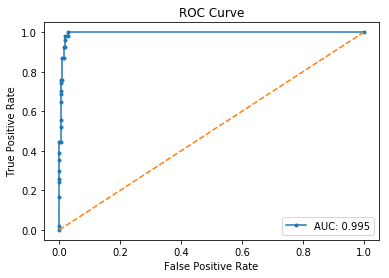

AUC: 0.998


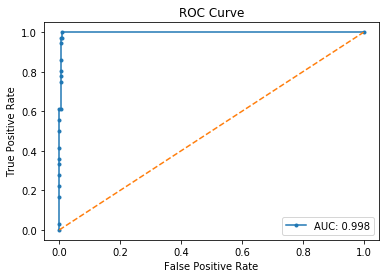

AUC: 0.998


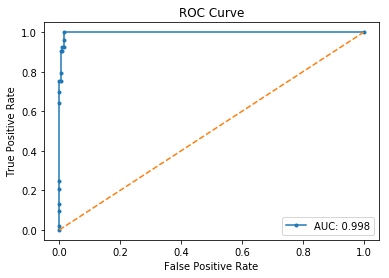

AUC: 0.996


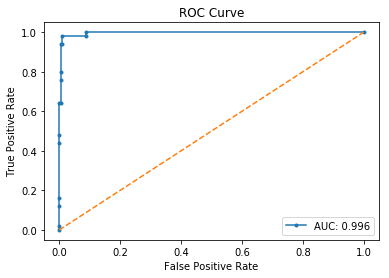

AUC: 0.998


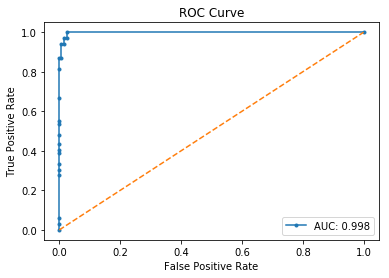

In [21]:
plotRocCurve(toLabelArray(l1),probabilities[0],"./images/p1-roc-gpflow.pdf")
plotRocCurve(toLabelArray(l2),probabilities[1],"./images/p2-roc-gpflow.pdf")
plotRocCurve(toLabelArray(l3),probabilities[2],"./images/p3-roc-gpflow.pdf")
plotRocCurve(toLabelArray(l4),probabilities[3],"./images/p4-roc-gpflow.pdf")
plotRocCurve(toLabelArray(l5),probabilities[4],"./images/p5-roc-gpflow.pdf")

f1=0.914 auc=0.976 ap=0.977


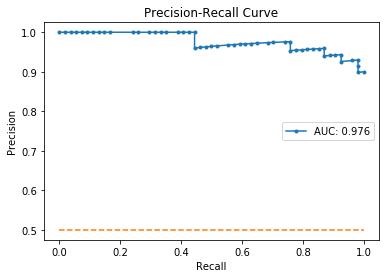

f1=0.986 auc=0.993 ap=0.993


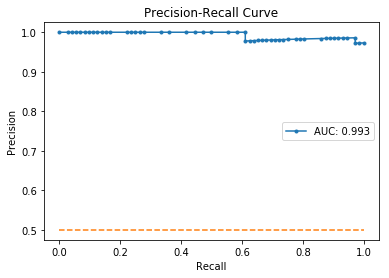

f1=0.942 auc=0.992 ap=0.992


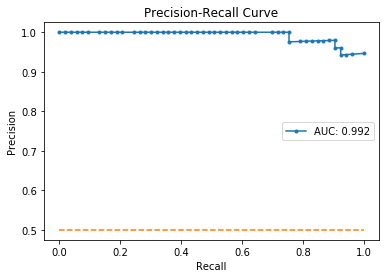

f1=0.961 auc=0.986 ap=0.986


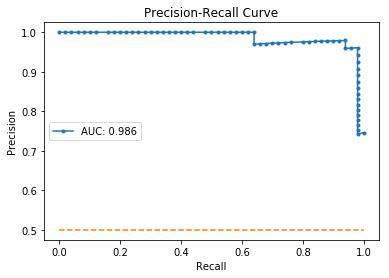

f1=0.957 auc=0.996 ap=0.996


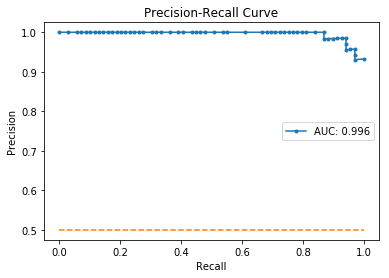

In [22]:
plotPrecisionRecallCurve(toLabelArray(l1),probabilities[0],"./images/p1-curve-gpflow.pdf")
plotPrecisionRecallCurve(toLabelArray(l2),probabilities[1],"./images/p2-curve-gpflow.pdf")
plotPrecisionRecallCurve(toLabelArray(l3),probabilities[2],"./images/p3-curve-gpflow.pdf")
plotPrecisionRecallCurve(toLabelArray(l4),probabilities[3],"./images/p4-curve-gpflow.pdf")
plotPrecisionRecallCurve(toLabelArray(l5),probabilities[4],"./images/p5-curve-gpflow.pdf")

In [23]:
labels = [l1,l2,l3,l4,l5]
dataframe = pd.DataFrame(columns=list(calculateMetrics(toLabelArray(l1),getLabelsPredicted(probabilities[0])).keys()))
for ind in range(len(labels)):
    dataframe.loc[ind] = calculateMetrics(toLabelArray(labels[ind]),
                                         getLabelsPredicted(probabilities[ind]))

print(dataframe)

        acc  precision  specificity    recall   f1score
0  0.964981   0.941176     0.985222  0.888889  0.914286
1  0.992908   0.972973     0.990476  1.000000  0.986301
2  0.976834   0.960784     0.990291  0.924528  0.942308
3  0.983740   0.942308     0.984694  0.980000  0.960784
4  0.977612   0.943662     0.979899  0.971014  0.957143


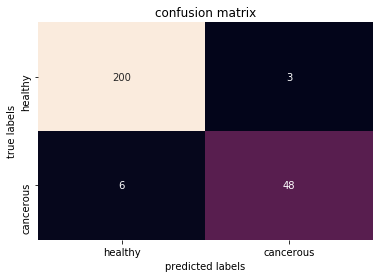

In [24]:
plotConfusionMatrix(toLabelArray(l1),
                   getLabelsPredicted(probabilities[0]),
                   "./images/confusion_mat1_gpflow.pdf")

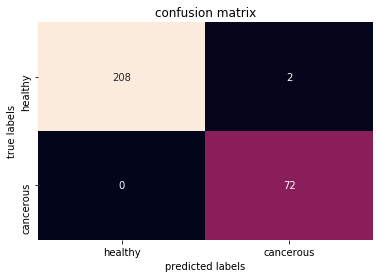

In [25]:
plotConfusionMatrix(toLabelArray(l2),
                   getLabelsPredicted(probabilities[1]),
                   "./images/confusion_mat2_gpflow.pdf")

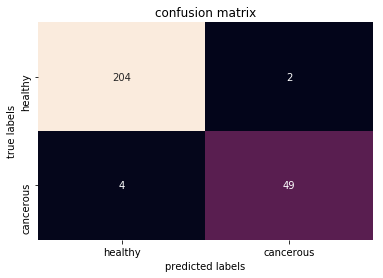

In [26]:
plotConfusionMatrix(toLabelArray(l3),
                   getLabelsPredicted(probabilities[2]),
                   "./images/confusion_mat3_gpflow.pdf")

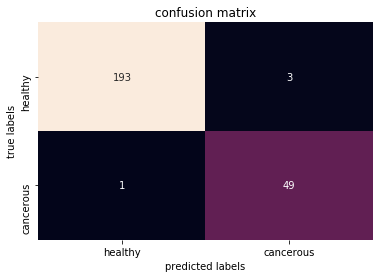

In [27]:
plotConfusionMatrix(toLabelArray(l4),
                   getLabelsPredicted(probabilities[3]),
                   "./images/confusion_mat4_gpflow.pdf")

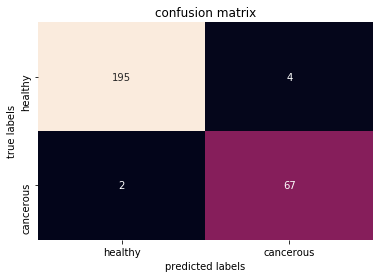

In [28]:
plotConfusionMatrix(toLabelArray(l5),
                   getLabelsPredicted(probabilities[4]),
                   "./images/confusion_mat5_gpflow.pdf")

In [29]:
models_linear = []
for ind in range(len(healthy)):
    print("training model {0:d}".format(ind))
    trainData,trainLabels = createTrainingSet(healthy,malign,ind)
    ker = gpflow.kernels.Linear(input_dim=10)
    lik = gpflow.likelihoods.Bernoulli()
    m = gpflow.models.VGP(trainData,trainLabels.T,
                                  kern=ker, likelihood=lik)
    # Optimizamos el modelo.
    gpflow.train.ScipyOptimizer().minimize(m,maxiter=250)
    models_linear.append(m)

training model 0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 303.124005
  Number of iterations: 250
  Number of functions evaluations: 276


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 303.124005
  Number of iterations: 250
  Number of functions evaluations: 276


training model 1
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 237.371208
  Number of iterations: 250
  Number of functions evaluations: 291


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 237.371208
  Number of iterations: 250
  Number of functions evaluations: 291


training model 2
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 280.911534
  Number of iterations: 250
  Number of functions evaluations: 276


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 280.911534
  Number of iterations: 250
  Number of functions evaluations: 276


training model 3
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 277.827650
  Number of iterations: 250
  Number of functions evaluations: 280


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 277.827650
  Number of iterations: 250
  Number of functions evaluations: 280


training model 4
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 284.652263
  Number of iterations: 250
  Number of functions evaluations: 278


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 284.652263
  Number of iterations: 250
  Number of functions evaluations: 278


In [30]:
probabilities = [calculateProbs(models_linear,data) for data in test_data ]

AUC: 0.981


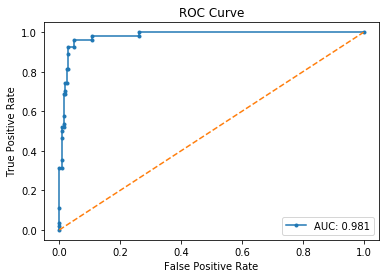

AUC: 0.980


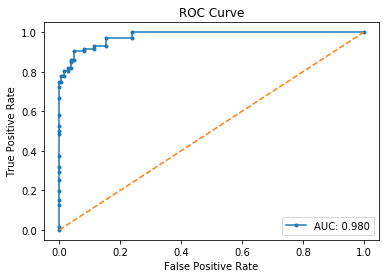

AUC: 0.966


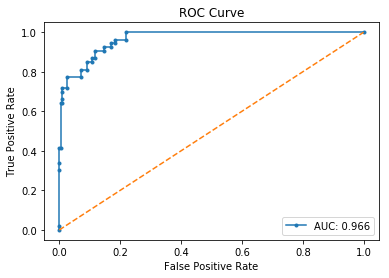

AUC: 0.952


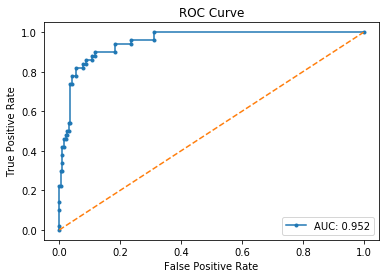

AUC: 0.959


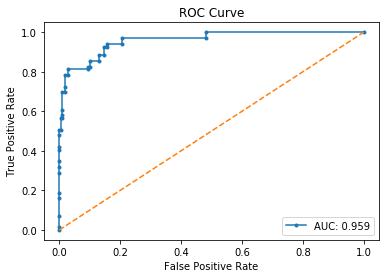

In [31]:
plotRocCurve(toLabelArray(l1),probabilities[0],"./images/p1-roc-gpflow-linear.pdf")
plotRocCurve(toLabelArray(l2),probabilities[1],"./images/p2-roc-gpflow-linear.pdf")
plotRocCurve(toLabelArray(l3),probabilities[2],"./images/p3-roc-gpflow-linear.pdf")
plotRocCurve(toLabelArray(l4),probabilities[3],"./images/p4-roc-gpflow-linear.pdf")
plotRocCurve(toLabelArray(l5),probabilities[4],"./images/p5-roc-gpflow-linear.pdf")

f1=0.792 auc=0.922 ap=0.924


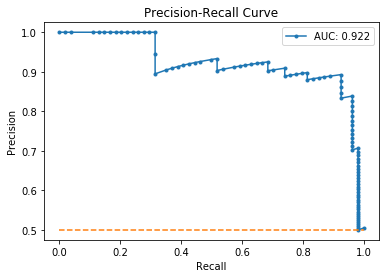

f1=0.798 auc=0.955 ap=0.955


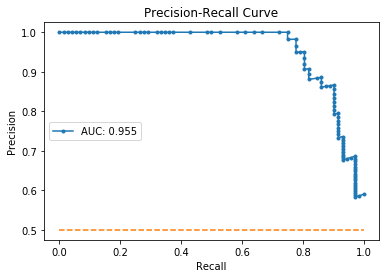

f1=0.683 auc=0.901 ap=0.902


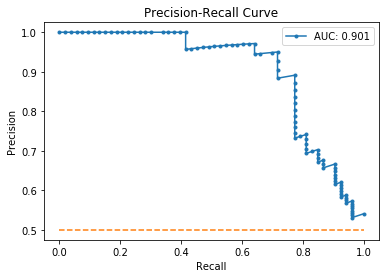

f1=0.761 auc=0.838 ap=0.840


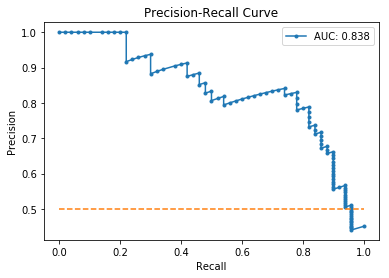

f1=0.844 auc=0.917 ap=0.918


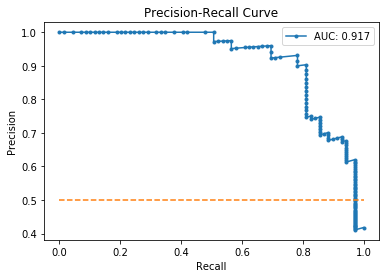

In [32]:
plotPrecisionRecallCurve(toLabelArray(l1),probabilities[0],"./images/p1-curve-gpflow-linear.pdf")
plotPrecisionRecallCurve(toLabelArray(l2),probabilities[1],"./images/p2-curve-gpflow-linear.pdf")
plotPrecisionRecallCurve(toLabelArray(l3),probabilities[2],"./images/p3-curve-gpflow-linear.pdf")
plotPrecisionRecallCurve(toLabelArray(l4),probabilities[3],"./images/p4-curve-gpflow-linear.pdf")
plotPrecisionRecallCurve(toLabelArray(l5),probabilities[4],"./images/p5-curve-gpflow-linear.pdf")

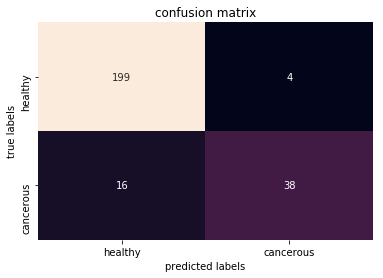

In [33]:
plotConfusionMatrix(toLabelArray(l1),
                   getLabelsPredicted(probabilities[0]),
                   "./images/confusion_mat1_gpflow_linear.pdf")

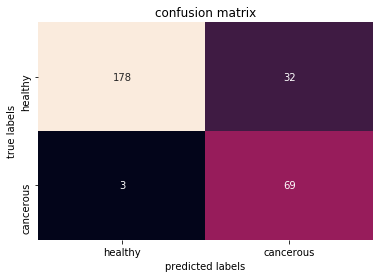

In [34]:
plotConfusionMatrix(toLabelArray(l2),
                   getLabelsPredicted(probabilities[1]),
                   "./images/confusion_mat2_gpflow_linear.pdf")

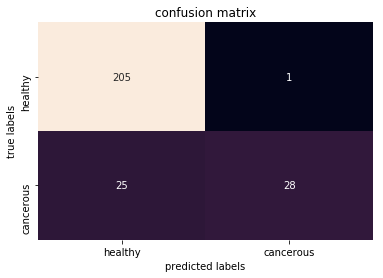

In [35]:
plotConfusionMatrix(toLabelArray(l3),
                   getLabelsPredicted(probabilities[2]),
                   "./images/confusion_mat3_gpflow_linear.pdf")

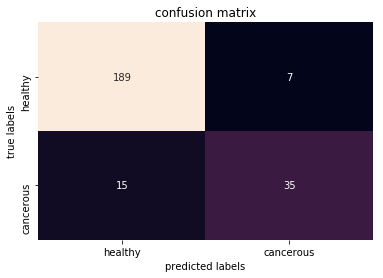

In [36]:
plotConfusionMatrix(toLabelArray(l4),
                   getLabelsPredicted(probabilities[3]),
                   "./images/confusion_mat4_gpflow_linear.pdf")

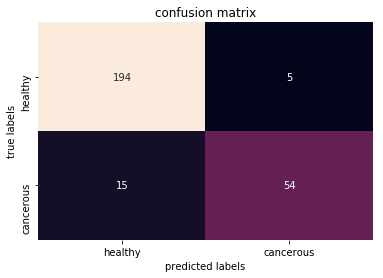

In [37]:
plotConfusionMatrix(toLabelArray(l5),
                   getLabelsPredicted(probabilities[4]),
                   "./images/confusion_mat5_gpflow_linear.pdf")

In [38]:
labels = [l1,l2,l3,l4,l5]
dataframe = pd.DataFrame(columns=list(calculateMetrics(toLabelArray(l1),getLabelsPredicted(probabilities[0])).keys()))
for ind in range(len(labels)):
    dataframe.loc[ind] = calculateMetrics(toLabelArray(labels[ind]),
                                         getLabelsPredicted(probabilities[ind]))

print(dataframe)

        acc  precision  specificity    recall   f1score
0  0.922179   0.904762     0.980296  0.703704  0.791667
1  0.875887   0.683168     0.847619  0.958333  0.797688
2  0.899614   0.965517     0.995146  0.528302  0.682927
3  0.910569   0.833333     0.964286  0.700000  0.760870
4  0.925373   0.915254     0.974874  0.782609  0.843750
